In [4]:
import glob
import numpy as np
import librosa
from librosa.feature import zero_crossing_rate, mfcc, spectral_centroid, spectral_rolloff, spectral_bandwidth, rms
import os
from scipy import signal
import warnings
import re
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
import numpy as np


In [5]:
# Constants
DEFAULT_SAMPLE_RATE = 44100
DEFAULT_FRAME_SIZE = 512

# initialize empty array for features
X = np.empty([0, 18])

# labels
y = []

def offset_audio_file(audio_file, range_size=5, sr=DEFAULT_SAMPLE_RATE):
    play_list = list()
    for offset in range(range_size):
        audio_data, sr_res = librosa.load(audio_file, sr=sr, mono=True, offset=offset, duration=5.0)
        play_list.append(audio_data)
    return play_list


def get_features(audio_data, sr=DEFAULT_SAMPLE_RATE, filter=None):

    # Teste filtrando as frequências de fala
    if filter:
        audio_data, sr = filter(audio_data, sr)
   
    zcr_feat = zero_crossing_rate(y=audio_data, hop_length=DEFAULT_FRAME_SIZE)
    rmse_feat = rms(y=audio_data, hop_length=DEFAULT_FRAME_SIZE)
    mfcc_feat = mfcc(y=audio_data, sr=sr, n_mfcc=13)
    spectral_centroid_feat = spectral_centroid(y=audio_data, sr=sr, hop_length=DEFAULT_FRAME_SIZE)
    spectral_rolloff_feat = spectral_rolloff(y=audio_data, sr=sr, hop_length=DEFAULT_FRAME_SIZE, roll_percent=0.90)
    spectral_bandwidth_feat = spectral_bandwidth(y=audio_data, sr=sr, hop_length=DEFAULT_FRAME_SIZE)

    concat_feat = np.concatenate((zcr_feat,
                                    rmse_feat,
                                    mfcc_feat,
                                    spectral_centroid_feat,
                                    spectral_rolloff_feat,
                                    spectral_bandwidth_feat
                                    ), axis=0)

    mean_feat = np.mean(concat_feat, axis=1, keepdims=True).transpose()
    return mean_feat

for audio_file in glob.glob("../baby_cry_detection/data/**/*.*"):
    ### TODO: Checar se tem que usar todo o offset
    mean_feat = get_features(offset_audio_file(audio_file, 1)[0])

    X = np.concatenate((X, mean_feat), axis=0)

    label = os.path.dirname(audio_file)
    y.append(label)

X

array([[ 5.28295389e-02,  1.16727541e-01, -3.25538496e+02, ...,
         2.48844691e+03,  6.36518487e+03,  3.08793732e+03],
       [ 1.07062745e-01,  5.35926912e-02, -3.41089369e+02, ...,
         3.55117010e+03,  7.64853380e+03,  2.79478271e+03],
       [ 6.19176878e-02,  6.49518877e-02, -2.53313343e+02, ...,
         2.69599891e+03,  6.27470545e+03,  2.87222626e+03],
       ...,
       [ 1.20738018e-01,  3.44135986e-02, -3.14948964e+02, ...,
         3.45249575e+03,  7.49455391e+03,  2.73159057e+03],
       [ 1.18918576e-01,  2.58630056e-02, -3.49385135e+02, ...,
         3.38067918e+03,  7.43440083e+03,  2.73095362e+03],
       [ 1.24057425e-01,  2.66647073e-02, -3.53010673e+02, ...,
         3.44359460e+03,  7.43185282e+03,  2.71639762e+03]])

In [6]:
def perf(y_test, y_pred):
    acc = {'accuracy': accuracy_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred, average='macro'),
            'precision': precision_score(y_test, y_pred, average='macro'),
            'f1': f1_score(y_test, y_pred, average='macro'),
            # 'summary': classification_report(y_test, y_pred)
            }
    return acc

global estimator_aux

class TrainClassifier:
    """
    Class to train a classifier of audio signals
    """

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def train(self):
        """
        Train Random Forest

        :return: pipeline, best_param, best_estimator, perf
        """

        # Split into training and test set
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y,
                                                            test_size=0.25,
                                                            random_state=0,
                                                            stratify=self.y)

        pipeline = Pipeline([
            ('scl', StandardScaler()),
            # ('lda', LinearDiscriminantAnalysis()),
            ('clf', SVC(probability=True))
        ])

        # GridSearch
        param_grid = [{'clf__kernel': ['linear', 'rbf'],
                       'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
                       'clf__gamma': np.logspace(-2, 2, 5),
                       # 'lda__n_components': range(2, 17)
                       }]

        estimator = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', return_train_score=True)
        global estimator_aux
        estimator_aux = estimator
        
        model = estimator.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        acc = perf(y_test, y_pred)

        return acc, model.best_params_, model.best_estimator_


train_classifier = TrainClassifier(X, y)
performance, parameters, best_estimator = train_classifier.train()

print(performance)
print(parameters)

model = best_estimator

{'accuracy': 0.9629629629629629, 'recall': 0.962962962962963, 'precision': 0.9660714285714286, 'f1': 0.9622966507177034}
{'clf__C': 1, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}


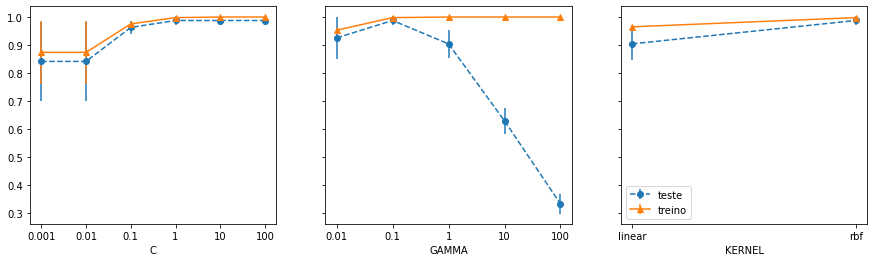

In [7]:
import matplotlib.pyplot as plt

#https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    subs_labels = {'clf__kernel': ['linear', 'rbf'],
                       'clf__C': ['0.001', '0.01', '0.1', '1', '10', '100'],
                       'clf__gamma': ['0.01', '0.1', '1', '10', '100']}

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid[0]
    
    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(15,4))
    #fig.suptitle('Score por parâmetro')
    #fig.text(0.04, 0.5, 'Score médio', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(subs_labels[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='teste')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='treino' )
        ax[i].set_xlabel(p[5:].upper())

    plt.legend()
    plt.show()


plot_search_results(estimator_aux)



In [8]:
# Bloco de apoio pra conversão do Sklearn pro Torch pra rodar no dispositivo móvel.

import sk2torch
import torch
import torch.jit
import re

# Torch precisa de y inteiro
r = re.compile('Crying baby')
y_to = [ (1 if r.search(x) else 0) for x in y ]

train_classifier_to = TrainClassifier(X, y_to)
performance_to, parameters_to, best_estimator_to = train_classifier_to.train()


In [9]:
#https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769
# def plotSVC(title, svc, X, y):
#   # create a mesh to plot in
#   x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
#   y_min, y_max = y[:, 0].min() - 1, y[:, 0].max() + 1
#   h = (x_max / x_min)/100
#   xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
#   plt.subplot(1, 1, 1)
#   Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
#   Z = Z.reshape(xx.shape)
#   plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
#   plt.scatter(X[:, 0], Y[:, 0], c=y, cmap=plt.cm.Paired)
#   plt.xlabel('Sepal length')
#   plt.ylabel('Sepal width')
#   plt.xlim(xx.min(), xx.max())
#   plt.title(title)
#   plt.show()

# kernels = ['linear'] #, 'rbf']
# for kernel in kernels:
#   svc = SVC(kernel=kernel, C=1, gamma=0.1).fit(X, y_to)
#   plotSVC('kernel=' + str(kernel), svc, X, y_to)


In [10]:
#_global_is_full_backward_hook = False
torch_model = sk2torch.wrap(best_estimator_to)

#torch_model.__setstate__({'_is_full_backward_hook': False})
torch_model._is_full_backward_hook = False

torch.jit.script(torch_model).save("../app/assets/models/sample1.pt")
#torch.save(torch_model.state_dict(), "../app/assets/models/sample2.pt")


In [11]:
from sklite import LazyExport
lazy = LazyExport(best_estimator_to[1])
lazy.save('../app/assets/models/svc-1.json', force_override = True)



In [12]:
# Dados pra teste do modelo Torch no Android
results = []

scaler = best_estimator_to[0] # Teste com scales

for audio_file in glob.glob('my_data/*.ogg'):
    # https://stackoverflow.com/questions/41146759/check-sklearn-version-before-loading-model-using-joblib
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        
    pd.options.display.max_colwidth = 1000

    audio_part = 0
    for audio_data in offset_audio_file(audio_file):
        audio_part = audio_part + 1
        features = get_features(audio_data)
        result = best_estimator_to.predict(features)
        scaled = scaler.transform(features)
        results.append([os.path.basename(audio_file), audio_part, features, result, scaled])

pd.DataFrame(results, columns=["file", "part", "features", "result", "scaled"])



,file,part,features,result,scaled
0,bebe-brabo.ogg,1,"[[0.08425513884860789, 0.007157335261733136, -544.6787352949174, 90.04269472462948, 27.005171838603275, 16.735045505432616, -7.575647929946951, 6.1577480895889884, -5.510552885844923, 7.774845899326896, -6.985728886153488, 28.159047428803763, 1.7538337366279482, 20.563135138174776, 15.638726289822717, 4236.215382559566, 10818.860797926334, 4575.613928241699]]",[0],"[[0.868475439999374, -1.2046462294884468, -2.6052664635713163, -0.5271239914059516, 0.8344405709303401, -0.10679292813810543, -0.20575417351603756, 0.17946626571273236, -0.44603948407780947, 0.3693721105057004, -0.6907928492387897, 2.499300541769131, 0.1935111185107234, 2.4683943626155282, 1.9121361547393476, 2.1619661728255113, 1.6889533956163312, 1.1658773331206809]]"
1,bebe-brabo.ogg,2,"[[0.08848539914443156, 0.0042314763261132775, -571.153285192503, 87.04244416274493, 29.83797372936373, 26.956140888124498, -3.3837960125260453, 16.66951503407582, -2.3640472763790608, 16.251995559704, -9.461168996384691, 31.992553281673423, -5.509478468249126, 19.50692504436953, 12.502985830788269, 4789.834259123975, 12294.409802784223, 5036.777157028667]]",[0],"[[0.9756361830460387, -1.238652781843705, -2.9006884932157297, -0.5966910331995835, 0.8996875045363765, 0.5431336107929393, 0.03859362665312126, 0.8724580373819537, -0.2233102727981043, 1.059813000961584, -0.9009103813154083, 2.872175935782941, -0.57950637557406, 2.3422930930293058, 1.5258933177891225, 2.818300144688251, 2.3079057599864132, 1.5609016586526494]]"
2,bebe-brabo.ogg,3,"[[0.09432438188805105, 0.0026152288636274792, -583.9935496744037, 66.71974784868776, 40.471280088695735, 31.402940569510317, 5.02442548273611, 19.108926489326905, 6.190675983875298, 18.466067627003188, -2.1856191158640415, 28.78130973740686, -2.816222555278487, 18.72916259898387, 11.067213150886538, 5256.178351929832, 13556.425373404873, 5421.542746158444]]",[0],"[[1.1235490029877926, -1.25743803607553, -3.043969380297406, -1.067914964227283, 1.1446007250135544, 0.8258912818676815, 0.5287183892106738, 1.0332770581167376, 0.382246176470725, 1.240143176896162, -0.283355313399604, 2.5598264187093305, -0.2928693870971446, 2.249435779531882, 1.3490429309839498, 3.371166897688832, 2.83728670140946, 1.8904851073020486]]"
3,bebe-brabo.ogg,4,"[[0.093248123912413, 0.003475363168183697, -556.3235873689231, 72.21590171336021, 34.8943733120739, 32.29676444486233, 2.4016527761024555, 19.877979822992724, 3.3730397508792977, 19.0509745278104, -3.7527039971055673, 27.58668970785119, -2.9930687660476725, 16.5364059041278, 9.693944237348376, 5057.922205540029, 13328.103474840487, 5312.0724311287595]]",[0],"[[1.0962852895720638, -1.2474409026169246, -2.7352080810084254, -0.9404752195388484, 1.0161497848443428, 0.8827266635925388, 0.3758339949537443, 1.0839771578259227, 0.1827963824006447, 1.287782260504031, -0.4163708553390521, 2.443628757530879, -0.3116907196835908, 1.9876418384052166, 1.17989140585299, 3.136127505943883, 2.741511923012654, 1.796714757323973]]"
4,bebe-brabo.ogg,5,"[[0.1041897023636891, 0.0034548881344320017, -532.4526086439943, 70.02801130431988, 20.533173541251024, 34.674429678308435, 4.3502541640795025, 23.956170634023, 4.02419294752267, 22.188594037584807, -2.9960259092829067, 24.722001386076006, -4.6762078073212825, 13.058255686578093, 7.810303989737327, 5106.237937691021, 13152.79022712442, 5147.323186051407]]",[0],"[[1.373456809750073, -1.2476788789932893, -2.468838567199988, -0.9912060036470899, 0.6853733013189219, 1.0339147386521925, 0.4894201788024597, 1.3528332588283576, 0.22888905023963735, 1.5433328753959739, -0.3521433542443466, 2.1649877882183954, -0.4908233092214531, 1.57238434293435, 0.9478752162047752, 3.1934074465826625, 2.6679728207381697, 1.6555934463517892]]"
5,bebe-chorando-banheiro.ogg,1,"[[0.09838470671403712, 0.06194486488499726, -284.2549179147955, 90.7430011457191, -48.58120716772887, 28.129970379121897, -12.112669431278158, 13.186070172665014, -10.377997044966559, 6.

In [13]:
pd.DataFrame([scaler.mean_, scaler.var_])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.049971,0.110803,-311.205094,112.776219,-9.223425,18.414529,-4.045880,3.435483,0.790667,3.239740,1.152651,2.463913,-0.064407,-0.111859,0.114910,2412.593058,6.792487e+03,3.214534e+03
1,0.001558,0.007403,8031.033092,1859.978735,1885.003648,247.324044,294.303209,230.088700,199.573403,150.746311,138.797059,105.697523,88.285784,70.155498,65.911219,711495.260635,5.683198e+06,1.362893e+06


In [14]:
# Teste com SR = 8000
X2 = np.empty([0, 18])
SR2 = 8000
for audio_file in glob.glob("../baby_cry_detection/data/**/*.*"):
    ### TODO: Checar se tem que usar todo o offset
    mean_feat2 = get_features(offset_audio_file(audio_file, 1, sr=SR2)[0], SR2)

    X2 = np.concatenate((X2, mean_feat2), axis=0)

X2


array([[ 1.72412727e-01,  1.22148783e-01, -2.01941103e+02, ...,
         9.45310745e+02,  1.82772943e+03,  6.90083353e+02],
       [ 4.51703422e-01,  5.11538505e-02, -2.78883876e+02, ...,
         1.97581842e+03,  3.07055973e+03,  8.68826185e+02],
       [ 2.50000000e-01,  7.09772441e-02, -1.32587510e+02, ...,
         1.45042225e+03,  2.91490309e+03,  9.71766764e+02],
       ...,
       [ 3.28335146e-01,  3.60118378e-02, -2.07642326e+02, ...,
         1.57006447e+03,  2.87054984e+03,  8.89057900e+02],
       [ 3.36567939e-01,  2.75653460e-02, -2.48123540e+02, ...,
         1.54909504e+03,  2.83099288e+03,  8.81002930e+02],
       [ 3.49065467e-01,  2.84443785e-02, -2.51899636e+02, ...,
         1.58154823e+03,  2.83929984e+03,  8.71192050e+02]])

In [15]:
len(X)

432

In [16]:
train_classifier2 = TrainClassifier(X2, y)
performance2, parameters2, best_estimator2 = train_classifier2.train()

print("Teste sr=8000")
print(performance2)
print(parameters2)

model2 = best_estimator2

Teste sr=8000
{'accuracy': 0.9259259259259259, 'recall': 0.9259259259259258, 'precision': 0.935064935064935, 'f1': 0.9249999999999999}
{'clf__C': 10, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}


In [17]:
# Não tá funcionando com mp3 pq não consegui colocar o ffmpeg no env do jupyter. 
# Como contorno converti todos os testes pra ogg via ffmpeg manualmente. Ogg funciona normalmente.

class BabyCryPredictor:
    """
    Class to classify a new audio signal and determine if it's a baby cry
    """

    def __init__(self, model):
        self.model = model

    def classify(self, new_signal):
        """
        Make prediction with trained model

        :param new_signal: 1d array, 34 features
        :return: 1 (it's baby cry); 0 (it's not a baby cry)
        """

        category = self.model.predict(new_signal)

        # category is an array of the kind array(['004 - Baby cry'], dtype=object)
        return self._is_baby_cry(category[0])

    @staticmethod
    def _is_baby_cry(value):
        """
        String analysis to detect if it is the baby cry category
        :param string: output of model prediction as string
        :return: 1 (it's baby cry); 0 (it's not a baby cry)
        """

        # Para o Torch a predição resposta tem que ser int. Daí já deixei a classe preparada.
        if value is int:
            return value

        #print(string)
        match = re.search('Crying baby', value)

        if match:
            return 1
        else:
            return 0


class MajorityVoter:
    """
    Class to make a majority vote over multiple (5 or more? odd number anyway) classifications
    """

    def __init__(self, prediction_list):
        self.predictions = prediction_list

    def vote(self):
        """
        Overall prediction

        :return: 1 if more than half predictions are 1s
        """

        if sum(self.predictions) > len(self.predictions)/2.0:
            return 1
        else:
            return 0

def predict(model, path, sr=DEFAULT_SAMPLE_RATE, filter=None):

    print("Predicting...", sr, path)

    predictor = BabyCryPredictor(model)

    results = []

    for audio_file in glob.glob(path):
        play_list = offset_audio_file(audio_file, sr=sr)
        play_list_processed = list()

        for signal in play_list:
            tmp = get_features(signal, sr=sr, filter=filter)
            play_list_processed.append(tmp)

        # https://stackoverflow.com/questions/41146759/check-sklearn-version-before-loading-model-using-joblib
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)

        predictions = list()

        for signal in play_list_processed:
            tmp = predictor.classify(signal)
            predictions.append(tmp)

        # MAJORITY VOTE

        majority_voter = MajorityVoter(predictions)
        majority_vote = majority_voter.vote()

        results.append((os.path.basename(audio_file), majority_vote, predictions))

    print("Done")

    return pd.DataFrame(results, columns=["file", "result", "partials"])
    #return np.array(results, dtype=[('file', 'U25'), ('after_voting', np.bool_), ('before_voting', np.bool_, (1, 5))])

predict(model, "my_data/*.ogg")


Predicting... 44100 my_data/*.ogg
Done


,file,result,partials
0,bebe-brabo.ogg,0,"[0, 0, 0, 0, 0]"
1,bebe-chorando-banheiro.ogg,1,"[1, 1, 1, 1, 1]"
2,bebe-chorando.ogg,1,"[0, 0, 1, 1, 1]"
3,bebe-falando.ogg,0,"[0, 0, 0, 0, 0]"


In [18]:
predict(model2, "my_data/*.ogg", SR2)


Predicting... 8000 my_data/*.ogg
Done


,file,result,partials
0,bebe-brabo.ogg,0,"[0, 0, 0, 0, 0]"
1,bebe-chorando-banheiro.ogg,1,"[0, 1, 1, 1, 1]"
2,bebe-chorando.ogg,1,"[1, 1, 1, 1, 1]"
3,bebe-falando.ogg,0,"[0, 0, 0, 0, 0]"


In [19]:
# O corpus é em sr=8000

result_df = predict(model2, "../donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/*/*", SR2)

result_df


Predicting... 8000 ../donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/*/*
Done


,file,result,partials
0,549a46d8-9c84-430e-ade8-97eae2bef787-1430130772174-1.7-m-48-bp.wav,0,"[0, 0, 0, 0, 0]"
1,643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138495-1.0-m-72-bp.wav,0,"[1, 1, 0, 0, 0]"
2,643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138506-1.0-m-72-bp.wav,0,"[0, 0, 0, 1, 1]"
3,643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138514-1.0-m-72-bp.wav,0,"[0, 0, 0, 0, 0]"
4,643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138524-1.0-m-72-bp.wav,1,"[1, 1, 1, 1, 1]"
...,...,...,...
452,d5abedab-9ed5-48d0-a83b-fc00c33d6d6b-1430079192907-1.7-f-04-ti.wav,0,"[0, 0, 0, 0, 0]"
453,d6cda191-4962-4308-9a36-46d5648a95ed-1431587887997-1.7-m-04-ti.wav,1,"[1, 1, 1, 1, 1]"
454,d6cda191-4962-4308-9a36-46d5648a95ed-1431587899682-1.7-m-04-ti.wav,0,"[0, 0, 0, 0, 0]"
455,d6cda191-4962-4308-9a36-46d5648a95ed-1431616581736-1.7-m-04-ti.wav,1,"[1, 1, 1, 1, 1]"


In [20]:
# Coloquei só alguns zeros pra parar o alerta de cálculo viciado (deixando um pouco mais viciado hehehe)
acc = perf(np.concatenate((result_df['result'], [0,0,0,0])), np.concatenate((np.full(len(result_df), 1), [0,0,0,0])))

print(acc)


{'accuracy': 0.44251626898047725, 'recall': 0.5076628352490421, 'precision': 0.7188183807439825, 'f1': 0.3195083426667815}


In [21]:
# Teste com filtro de banda

lowcut = 250.0
highcut = 1000.0

# https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
def bandpass_filter(audio_data, sr):
    order = 3.0  #3, 6 , 9
    # 6 ficou instável

    nyq = 0.5 * float(sr)
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')

    y = signal.lfilter(b, a, audio_data)
    
    return y, sr    

X3 = np.empty([0, 18])
y3 = []
for audio_file in glob.glob("../baby_cry_detection/data/**/*.*"):
    ### TODO: Checar se tem que usar todo o offset
    mean_feat = get_features(offset_audio_file(audio_file, 1)[0], filter=bandpass_filter)

    X3 = np.concatenate((X3, mean_feat), axis=0)

    label = os.path.dirname(audio_file)
    y3.append(label)

train_classifier3 = TrainClassifier(X3, y3)
performance3, parameters3, best_estimator3 = train_classifier2.train()

print("Teste sr=", DEFAULT_SAMPLE_RATE, 'filtered')
print(performance3)
print(parameters3)

model3 = best_estimator3



Teste sr= 44100 filtered
{'accuracy': 0.9259259259259259, 'recall': 0.9259259259259258, 'precision': 0.935064935064935, 'f1': 0.9249999999999999}
{'clf__C': 10, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}


In [22]:
# Teste com SR = 8000 e filtro
X4 = np.empty([0, 18])
for audio_file in glob.glob("../baby_cry_detection/data/**/*.*"):
    ### TODO: Checar se tem que usar todo o offset
    mean_feat2 = get_features(offset_audio_file(audio_file, 1, sr=SR2)[0], SR2, filter=bandpass_filter)

    X4 = np.concatenate((X4, mean_feat2), axis=0)

train_classifier4 = TrainClassifier(X4, y3)
performance4, parameters4, best_estimator4 = train_classifier4.train()

print("Teste sr=", SR2, 'filtered')
print(performance4)
print(parameters4)

model4 = best_estimator4

Teste sr= 8000 filtered
{'accuracy': 0.9259259259259259, 'recall': 0.9259259259259259, 'precision': 0.9276656314699794, 'f1': 0.9247527910685805}
{'clf__C': 1, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}


In [23]:
predict(model3, "my_data/*.ogg", filter=bandpass_filter)


Predicting... 44100 my_data/*.ogg
Done


,file,result,partials
0,bebe-brabo.ogg,0,"[0, 0, 0, 0, 0]"
1,bebe-chorando-banheiro.ogg,0,"[0, 0, 0, 0, 0]"
2,bebe-chorando.ogg,0,"[0, 0, 0, 0, 0]"
3,bebe-falando.ogg,0,"[0, 0, 0, 0, 0]"


In [24]:
predict(model4, "my_data/*.ogg", SR2, filter=bandpass_filter)


Predicting... 8000 my_data/*.ogg
Done


,file,result,partials
0,bebe-brabo.ogg,0,"[0, 0, 0, 0, 0]"
1,bebe-chorando-banheiro.ogg,1,"[1, 1, 1, 1, 1]"
2,bebe-chorando.ogg,1,"[1, 1, 1, 1, 1]"
3,bebe-falando.ogg,0,"[0, 0, 0, 0, 0]"


In [25]:
result_df4 = predict(model4, "../donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/*/*", SR2, filter=bandpass_filter)

result_df4

Predicting... 8000 ../donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/*/*
Done


,file,result,partials
0,549a46d8-9c84-430e-ade8-97eae2bef787-1430130772174-1.7-m-48-bp.wav,1,"[1, 1, 1, 1, 0]"
1,643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138495-1.0-m-72-bp.wav,0,"[0, 0, 0, 0, 0]"
2,643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138506-1.0-m-72-bp.wav,0,"[0, 0, 0, 0, 1]"
3,643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138514-1.0-m-72-bp.wav,1,"[1, 1, 1, 1, 1]"
4,643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138524-1.0-m-72-bp.wav,1,"[1, 1, 1, 1, 0]"
...,...,...,...
452,d5abedab-9ed5-48d0-a83b-fc00c33d6d6b-1430079192907-1.7-f-04-ti.wav,0,"[0, 0, 0, 0, 0]"
453,d6cda191-4962-4308-9a36-46d5648a95ed-1431587887997-1.7-m-04-ti.wav,1,"[0, 0, 1, 1, 1]"
454,d6cda191-4962-4308-9a36-46d5648a95ed-1431587899682-1.7-m-04-ti.wav,1,"[1, 1, 1, 1, 1]"
455,d6cda191-4962-4308-9a36-46d5648a95ed-1431616581736-1.7-m-04-ti.wav,1,"[1, 1, 1, 1, 1]"


In [26]:
# Coloquei só alguns zeros pra parar o alerta de cálculo viciado (deixando um pouco mais viciado hehehe)
acc4 = perf(np.concatenate((result_df4['result'], [0,0,0,0])), np.concatenate((np.full(len(result_df4), 1), [0,0,0,0])))

print(acc4)

# 0,50... na moeda seria mais preciso.


{'accuracy': 0.5097613882863341, 'recall': 0.508695652173913, 'precision': 0.7527352297592997, 'f1': 0.3528498310475055}
